## Importing Packages

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import argparse
from IPython import display
import matplotlib.pyplot as plt
# %matplotlib inline
from tensorflow import keras

# we construct the argument parser

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=128, help="size of the batches")
parser.add_argument("--lr", type=float, default=2e-4, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--latent_dim", type=int, default=100, help="dimension of the latent space (generator's input)")
parser.add_argument("--image_dim", type=int, default=784, help="image size")
parser.add_argument("--channels", type=int, default=1, help="image channels")
args = parser.parse_args("")

## Then load the data and perform Data preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(60000).batch(args.batch_size)

4431872/4422102 [==============================] - 0s 0us/step


## Creating Generator Network

In [ ]:
def generator(image_dim):
  inputs = keras.Input(shape=(100,), name='input_layer')
  x = layers.Dense(128, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_1')(inputs)
  #print(x.dtype)
  x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
  x = layers.Dense(256, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_2')(x) 
  x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, name='bn_1')(x)
  x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
  x = layers.Dense(512, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_3')(x) 
  x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, name='bn_2')(x)
  x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
  x = layers.Dense(1024, kernel_initializer=tf.keras.initializers.he_uniform,  name='dense_4')(x) 
  x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, name='bn_3')(x)
  x = layers.LeakyReLU(0.2, name='leaky_relu_4')(x)
  x = layers.Dense(image_dim, kernel_initializer=tf.keras.initializers.he_uniform, activation='tanh',  name='dense_5')(x) 
  outputs = tf.reshape(x, [-1, 28, 28, 1], name='Reshape_Layer')
  model = tf.keras.Model(inputs, outputs, name="Generator")
  return model

In [ ]:
generator = generator(args.image_dim)

In [ ]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 256)               1024      
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               13

## Creating Discriminator Network

In [ ]:
def discriminator():
  inputs = keras.Input(shape=(28,28,1), name='input_layer')
  input = tf.reshape(inputs, [-1, 784], name='reshape_layer')
  x = layers.Dense(512, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_1')(input)
  x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
  x = layers.Dense(256, kernel_initializer=tf.keras.initializers.he_uniform, name='dense_2')(x) 
  x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
  outputs = layers.Dense(1, kernel_initializer=tf.keras.initializers.he_uniform, activation='sigmoid', name='dense_3') (x) 
  model = tf.keras.Model(inputs, outputs, name="Discriminator")
  return model

In [ ]:
discriminator = discriminator()

In [ ]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
tf.reshape_1 (TFOpLambda)    (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_relu_1 (LeakyReLU)     (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_relu_2 (LeakyReLU)     (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)               

## Loss Function

In [ ]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

## Generator Loss

In [ ]:
def generator_loss(fake_output):
  gen_loss = binary_cross_entropy(tf.ones_like(fake_output), fake_output)
  #print(gen_loss)
  return gen_loss

## Discriminator Loss

In [ ]:
def discriminator_loss(real_output, fake_output):
  real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = binary_cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  #print(total_loss)
  return total_loss

## Optimizers

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = args.lr, beta_1 = args.b1, beta_2 = args.b2 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = args.lr, beta_1 = args.b1, beta_2 = args.b2 )

## Training Loop (all the functions combined for training GAN)

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([args.batch_size, args.latent_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
      
      
  gradients_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables) # computing the gradients
  
  
  gradients_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables) # computing the gradients
      
  
  generator_optimizer.apply_gradients(zip(gradients_of_gen, generator.trainable_variables)) # updating generator parameter 
  
      
  discriminator_optimizer.apply_gradients(zip(gradients_of_disc,discriminator.trainable_variables)) # updating discriminator parameter

## Final training 

In [ ]:
# We will reuse this seed overtime to visualize progress
num_examples_to_generate = 25
seed = tf.random.normal([num_examples_to_generate, args.latent_dim])

In [ ]:
!mkdir tensor

In [ ]:
import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    i = 0
    D_loss_list, G_loss_list = [], []
    for image_batch in dataset:
      i += 1
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                              epoch + 1,
                              seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                          epochs,
                          seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    #print(predictions.shape)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)  
        pred = (predictions[i, :, :, 0] + 1) * 127.5  
        pred = np.array(pred)    
        plt.imshow(pred.astype(np.uint8), cmap='gray')
        plt.axis('off')

    plt.savefig('tensor/image_at_epoch_{:d}.png'.format(epoch))
    plt.show()

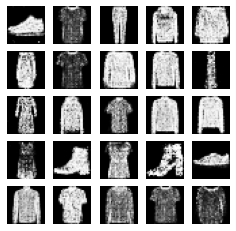

In [ ]:
train(train_dataset, args.n_epochs)